# Load in the Dataset + Packages

In [1]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    cross_validate,
    train_test_split,
)
from sklearn.feature_selection import RFE, SelectFromModel, RFECV
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
api_df = pd.read_excel("../../data/raw/train_essentials.xlsx")
api_df.head()

,is_pii,is_fii,NRI score,authentication_processed,usage_base_processed,AI & Data Science,Business & Technology,Environment & Weather,Finance & Banking,GeoInformatics & Navigation,...,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count,Risk_Label
0,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,Low
1,True,False,77.850013,1,2,0,0,0,0,0,...,0,0,0,1,0,0,0,6,1,Low
2,False,False,76.479613,1,2,0,1,0,0,0,...,0,0,0,1,0,0,0,3,1,Medium
3,True,False,76.479613,1,2,0,0,0,0,0,...,1,0,0,0,0,0,0,5,0,Low
4,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,3,Low


In [3]:
api_df.shape

(1316, 53)

In [4]:
# Train-test split
X_train, y_train = api_df.drop(columns=["Risk_Label"]), api_df["Risk_Label"]

In [5]:
# Smote function
def create_smote(X, y, k_neighbors):
    oversample = SMOTE(k_neighbors = k_neighbors)
    X, y = oversample.fit_resample(X, y)
    return X, y

In [6]:
# Balanced training data
X_train, y_train = create_smote(X_train, y_train, 2)

# Baseline Performance

In [7]:
results = {}
scoring_metric = ["accuracy", "f1_macro", "recall_macro"]

In [8]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [9]:
# Logistic Regression model
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
results["lr"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [10]:
# Decision Tree model
pipe_dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())
results["dt"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [11]:
pd.DataFrame(results)

,lr,dt
fit_time,0.040 (+/- 0.011),0.016 (+/- 0.012)
score_time,0.009 (+/- 0.010),0.011 (+/- 0.007)
test_accuracy,0.996 (+/- 0.003),0.997 (+/- 0.003)
train_accuracy,0.999 (+/- 0.000),1.000 (+/- 0.000)
test_f1_macro,0.996 (+/- 0.003),0.997 (+/- 0.003)
train_f1_macro,0.999 (+/- 0.000),1.000 (+/- 0.000)
test_recall_macro,0.996 (+/- 0.003),0.997 (+/- 0.003)
train_recall_macro,0.999 (+/- 0.000),1.000 (+/- 0.000)


# Feature Importance

In [12]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [13]:
data_coef = {
    "coefficient": pipe_lr.named_steps['logisticregression'].coef_.tolist()[0],
    "magnitude": np.absolute(pipe_lr.named_steps['logisticregression'].coef_)[0],
}
coef_df = pd.DataFrame(data_coef, index=X_train.columns).sort_values("magnitude", ascending=False)
coef_df

,coefficient,magnitude
is_fii,2.240168,2.240168
is_pii,0.976327,0.976327
Information & Science,-0.945960,0.945960
metadata_fields_count,-0.843867,0.843867
server,-0.841245,0.841245
x0_Missing,-0.824019,0.824019
Social Media & Technology,-0.683565,0.683565
Government & Public Services,-0.676761,0.676761
Software & Services,-0.648988,0.648988
parameters_count,-0.559112,0.559112


# Feature Selection using SelectFromModel

In [14]:
select_lr = SelectFromModel(LogisticRegression(), threshold="mean")

In [15]:
pipe_dt_model_based = make_pipeline(
    StandardScaler(), select_lr, DecisionTreeClassifier(random_state=42)
)
results["dt+model_based_fs"] = mean_std_cross_val_scores(
    pipe_dt_model_based, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [16]:
pd.DataFrame(results)

,lr,dt,dt+model_based_fs
fit_time,0.040 (+/- 0.011),0.016 (+/- 0.012),0.047 (+/- 0.010)
score_time,0.009 (+/- 0.010),0.011 (+/- 0.007),0.007 (+/- 0.008)
test_accuracy,0.996 (+/- 0.003),0.997 (+/- 0.003),0.998 (+/- 0.003)
train_accuracy,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_f1_macro,0.996 (+/- 0.003),0.997 (+/- 0.003),0.998 (+/- 0.003)
train_f1_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_recall_macro,0.996 (+/- 0.003),0.997 (+/- 0.003),0.998 (+/- 0.003)
train_recall_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)


In [17]:
pipe_dt_model_based.fit(X_train, y_train)
pipe_dt_model_based.named_steps["selectfrommodel"].n_features_in_

52

# Feature Selection using RFE

In [18]:
rfecv = RFECV(LogisticRegression())
pipe_dt_rfecv = make_pipeline(
    StandardScaler(), rfecv, DecisionTreeClassifier(random_state=42)
)
results["dt+rfecv"] = mean_std_cross_val_scores(
    pipe_dt_rfecv, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [19]:
pd.DataFrame(results)

,lr,dt,dt+model_based_fs,dt+rfecv
fit_time,0.040 (+/- 0.011),0.016 (+/- 0.012),0.047 (+/- 0.010),8.789 (+/- 0.980)
score_time,0.009 (+/- 0.010),0.011 (+/- 0.007),0.007 (+/- 0.008),0.005 (+/- 0.005)
test_accuracy,0.996 (+/- 0.003),0.997 (+/- 0.003),0.998 (+/- 0.003),0.997 (+/- 0.003)
train_accuracy,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.999 (+/- 0.001)
test_f1_macro,0.996 (+/- 0.003),0.997 (+/- 0.003),0.998 (+/- 0.003),0.997 (+/- 0.003)
train_f1_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.999 (+/- 0.001)
test_recall_macro,0.996 (+/- 0.003),0.997 (+/- 0.003),0.998 (+/- 0.003),0.997 (+/- 0.003)
train_recall_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.999 (+/- 0.001)


In [20]:
pipe_dt_rfecv.fit(X_train, y_train)
pipe_dt_rfecv.named_steps["rfecv"].n_features_

17

In [21]:
rfecv_fs = pipe_dt_rfecv.named_steps["rfecv"].support_
rfecv_selected_feats = X_train.columns[rfecv_fs]
rfecv_selected_feats

Index(['is_pii', 'is_fii', 'authentication_processed', 'Finance & Banking',
       'Government & Public Services', 'Information & Science',
       'Social Media & Technology', 'Software & Services',
       'Sports & Entertainment', 'security_test_result_processed',
       'x0_Broken Authentication', 'x0_Missing', 'content-type',
       'access-control-allow-origin', 'server', 'metadata_fields_count',
       'parameters_count'],
      dtype='object')

# Feature Selection using RFE

In [22]:
select_rfe = RFE(LogisticRegression(), n_features_to_select=8)
pipe_dt_rfe = make_pipeline(StandardScaler(), select_rfe, DecisionTreeClassifier(random_state=42))
results["dt+rfe"] = mean_std_cross_val_scores(
    pipe_dt_rfe, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [23]:
pd.DataFrame(results)

,lr,dt,dt+model_based_fs,dt+rfecv,dt+rfe
fit_time,0.040 (+/- 0.011),0.016 (+/- 0.012),0.047 (+/- 0.010),8.789 (+/- 0.980),1.610 (+/- 0.209)
score_time,0.009 (+/- 0.010),0.011 (+/- 0.007),0.007 (+/- 0.008),0.005 (+/- 0.005),0.011 (+/- 0.004)
test_accuracy,0.996 (+/- 0.003),0.997 (+/- 0.003),0.998 (+/- 0.003),0.997 (+/- 0.003),0.998 (+/- 0.003)
train_accuracy,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.999 (+/- 0.001),1.000 (+/- 0.000)
test_f1_macro,0.996 (+/- 0.003),0.997 (+/- 0.003),0.998 (+/- 0.003),0.997 (+/- 0.003),0.998 (+/- 0.003)
train_f1_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.999 (+/- 0.001),1.000 (+/- 0.000)
test_recall_macro,0.996 (+/- 0.003),0.997 (+/- 0.003),0.998 (+/- 0.003),0.997 (+/- 0.003),0.998 (+/- 0.003)
train_recall_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.999 (+/- 0.001),1.000 (+/- 0.000)


In [24]:
pipe_dt_rfe.fit(X_train, y_train)
pipe_dt_rfe.named_steps["rfe"].n_features_

8

In [25]:
rfe_fs = pipe_dt_rfe.named_steps["rfe"].support_
rfe_selected_feats = X_train.columns[rfe_fs]
rfe_selected_feats

Index(['is_pii', 'is_fii', 'authentication_processed', 'Information & Science',
       'x0_Broken Authentication', 'x0_Missing', 'server',
       'metadata_fields_count'],
      dtype='object')

In [26]:
n_feats = np.arange(1, 53)
train_scores = []
cv_scores = []

for n in n_feats:
    rfe = RFE(LogisticRegression(), n_features_to_select=n)
    pipe = make_pipeline(StandardScaler(), rfe, DecisionTreeClassifier())
    scores = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(scores["train_score"].mean())
    cv_scores.append(scores["test_score"].mean())

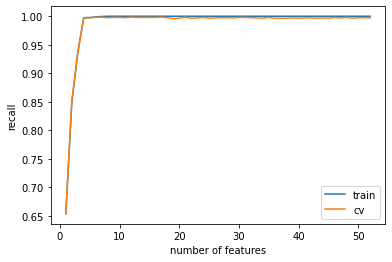

In [27]:
plt.plot(n_feats, train_scores, label="train")
plt.plot(n_feats, cv_scores, label="cv")
plt.legend()
plt.xlabel("number of features")
plt.ylabel("recall");